# Titanic, Machine Learning from Disaster

데이터 출처 : https://www.kaggle.com/c/titanic

The competition is simple : use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

Using the patterns you find in the train.csv data, predict whether the other passengers on board (found in test.csv) survived.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import missingno as msno

import warnings
warnings.filterwarnings('ignore')

In [2]:
## 한글 폰트 설정
import os
os.name

import os
if os.name == 'posix' :
    plt.rc('font', family='AppleGothic')    # 맥
else:
    plt.rc('font', family='Malgun Gothic')  # 윈도우

# 마이너스 폰트 깨지는 문제애 대한 대처
plt.rc('axes', unicode_minus=False)

# 레티나 설정을 해주면 글씨가 더 선명해짐
%config InlineBackend.figure_font = 'retina'

# 1. 데이터셋 확인

In [3]:
# train 데이터 불러오기
df_train = pd.read_csv("train.csv")

print(df_train.shape)
df_train.head(2)

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [4]:
## test 데이터 불러오기

# The test dataset contains similar information but does not disclose the “ground truth” for each passenger
# # It’s your job to predict these outcomes.
df_test = pd.read_csv("test.csv")

print(df_test.shape)
df_test.head(2)

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


In [5]:
# 변수 정보
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


변수 정보
- Survived : 생존 여부 (0 = No, 1 = Yes)
- Pclass : Ticket Class (1 = 1st, 2 = 2nd, 3 = 3rd)     
- Name : 이름
- Sex : 성별     
- Age : 나이   
- SibSp : 함께 탑승한 형제, 배우자 수     
- Parch : 함께 탑승한 부모, 자식 수
- Ticket : 티켓 번호     
- Fare : 탑승료
- Cabin : 객실 번호     
- Embarked : 탑승 항구 (C = Cherbourg, Q = Queenstown, S = Southampton)

In [7]:
# 수치 데이터 확인
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
df_test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


## 1.1 결측치 확인

In [9]:
# df_train
df_train.isna().sum() / len(df_train) * 100

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

In [10]:
# df_test
df_test.isna().sum() / len(df_test) * 100

PassengerId     0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            20.574163
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.239234
Cabin          78.229665
Embarked        0.000000
dtype: float64

Train, Test set에서 Age(약 20%), Cabin(약 80%), Embarked(약 0.22%, Train만) 칼럼이 NULL 데이터 존재

<Axes: >

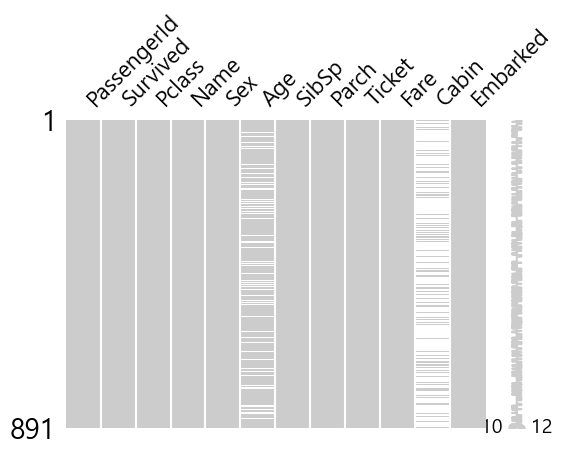

In [11]:
# 결측치 시각화 1
msno.matrix(df=df_train.iloc[:, :], figsize=(6, 4), color=(0.8, 0.8, 0.8))

<Axes: >

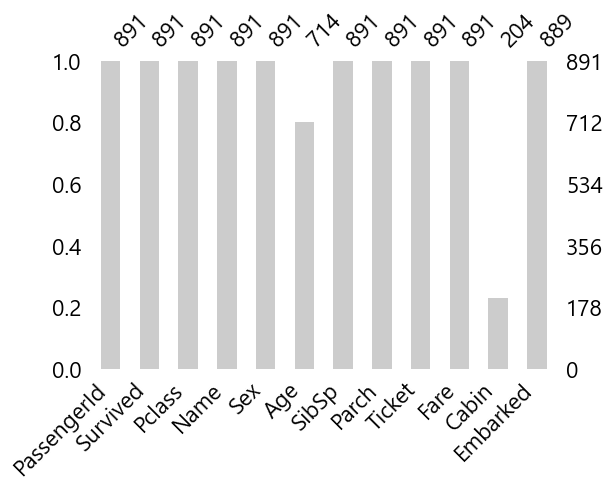

In [12]:
# 결측치 시각화 2
msno.bar(df=df_train.iloc[:, :], figsize=(6, 4), color=(0.8, 0.8, 0.8))

<Axes: >

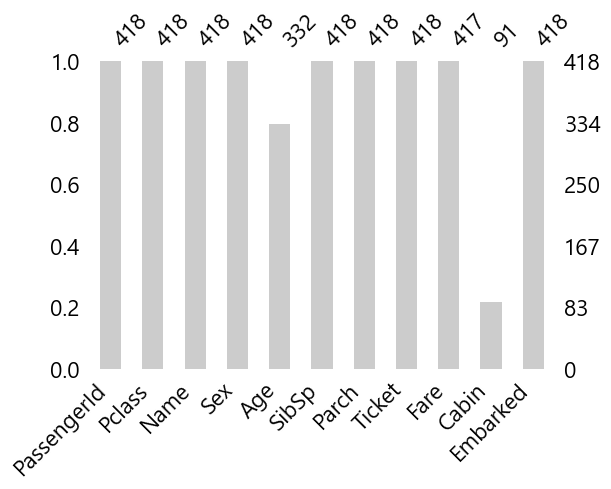

In [13]:
msno.bar(df=df_test.iloc[:, :], figsize=(6, 4), color=(0.8, 0.8, 0.8))

## 1.2 종속 변수 확인

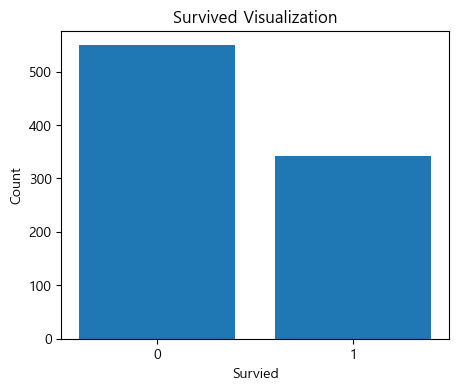

In [14]:
survive = df_train['Survived'].value_counts().sort_index()

# fig : 그래프의 빈 도면, 여기에 그래프의 모든 내용이 그려짐
# ax : 실제로 그래프와 plot을 그리는 데 사용되는 영역
fig, ax = plt.subplots(figsize=(5, 4))

ax.bar(survive.index, survive.values)
ax.set_xlabel('Survied')
ax.set_ylabel('Count')

ax.set_xticks([0, 1])

plt.title('Survived Visualization')
plt.show()

종속 변수의 분포가 균일한 편

# 2. EDA (Exploratory Data Analysis)

## 2.1 Pclass
- 카테고리이면서 순서가 있는 데이터

In [15]:
# Pclass 별 인원수
df_train[['Pclass', 'Survived']].groupby('Pclass').count()

,Survived
Pclass,
1,216
2,184
3,491


In [16]:
# Pclass 별 생존자
df_train[['Pclass', 'Survived']].groupby('Pclass').sum()

,Survived
Pclass,
1,136
2,87
3,119


In [17]:
## Pclass 별 사망자 vs 생존자

# margins=True : 행과 열의 합계를 추가
pd.crosstab(df_train['Pclass'], df_train['Survived'], margins=True).style.background_gradient(cmap='GnBu')

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


<Axes: xlabel='Pclass'>

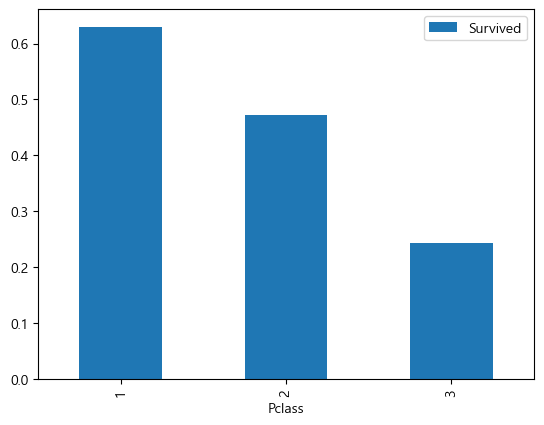

In [18]:
# Pclass 별 생존률
df_train[['Pclass', 'Survived']].groupby('Pclass').mean().plot.bar()

Text(0, 0.5, 'Count')

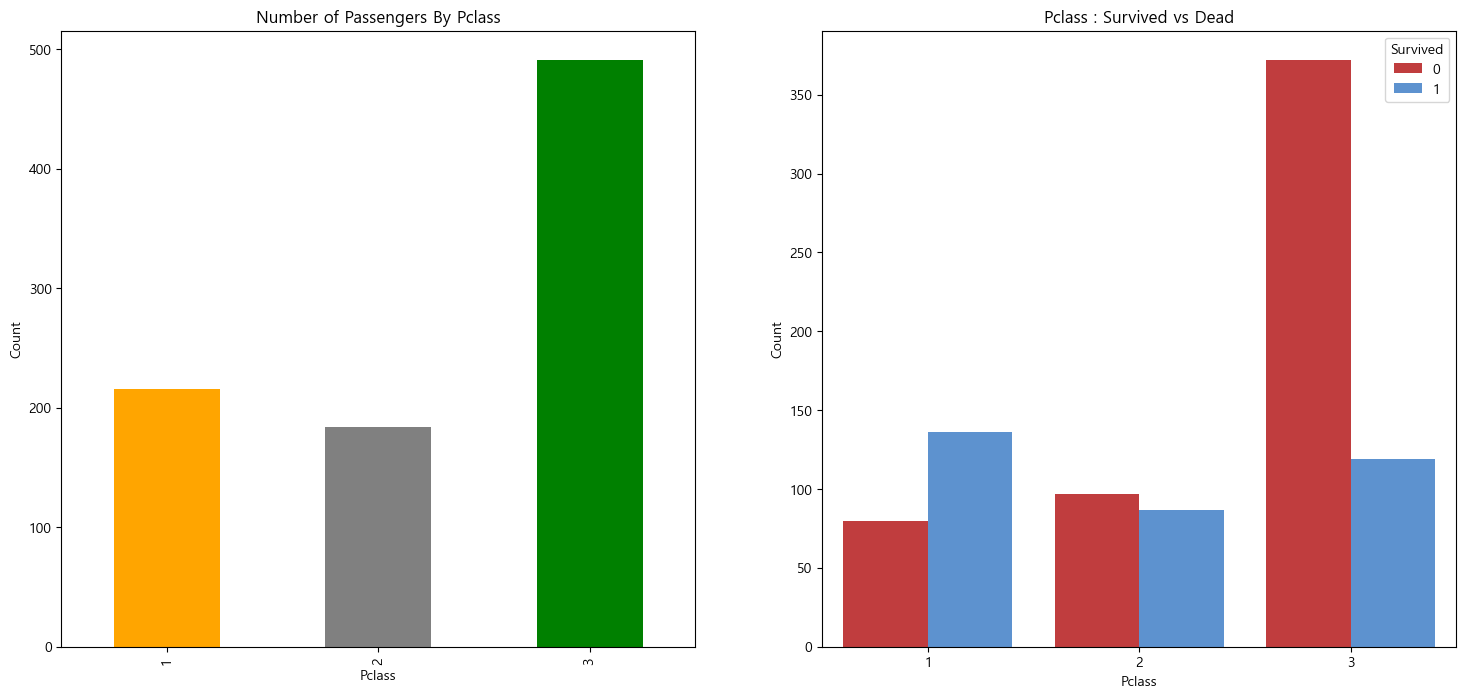

In [19]:
# 시각화

fig, ax = plt.subplots(1, 2, figsize=(18, 8))

df_train['Pclass'].value_counts().sort_index().plot.bar(color=['orange', 'gray', 'green'], ax=ax[0])
ax[0].set_title('Number of Passengers By Pclass')
ax[0].set_ylabel('Count')

sns.countplot(data=df_train, x='Pclass', hue='Survived', palette=['#d62728', '#4a90e2'], ax=ax[1])
ax[1].set_title('Pclass : Survived vs Dead')
ax[1].set_ylabel('Count')

Pclass 정리
- Pclass가 좋을수록 생존률이 높음
- 생존률 : Pclass 1, 2, 3 순서대로 63%, 48%, 25%
- 생존에 Pclass가 큰 영향을 미친다고 생각할 수 있음 > 모델을 만들 때 Pclass 변수를 사용하는 것이 좋음

## 2.2 Sex

In [20]:
# Sex 별 생존률
df_train[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.742038
male,0.188908


In [21]:
## Sex 별 사망자 vs 생존자
pd.crosstab(df_train['Sex'], df_train['Survived'], margins=True).style.background_gradient(cmap='GnBu')

Survived,0,1,All
Sex,,,
female,81,233,314
male,468,109,577
All,549,342,891


Text(0, 0.5, 'Count')

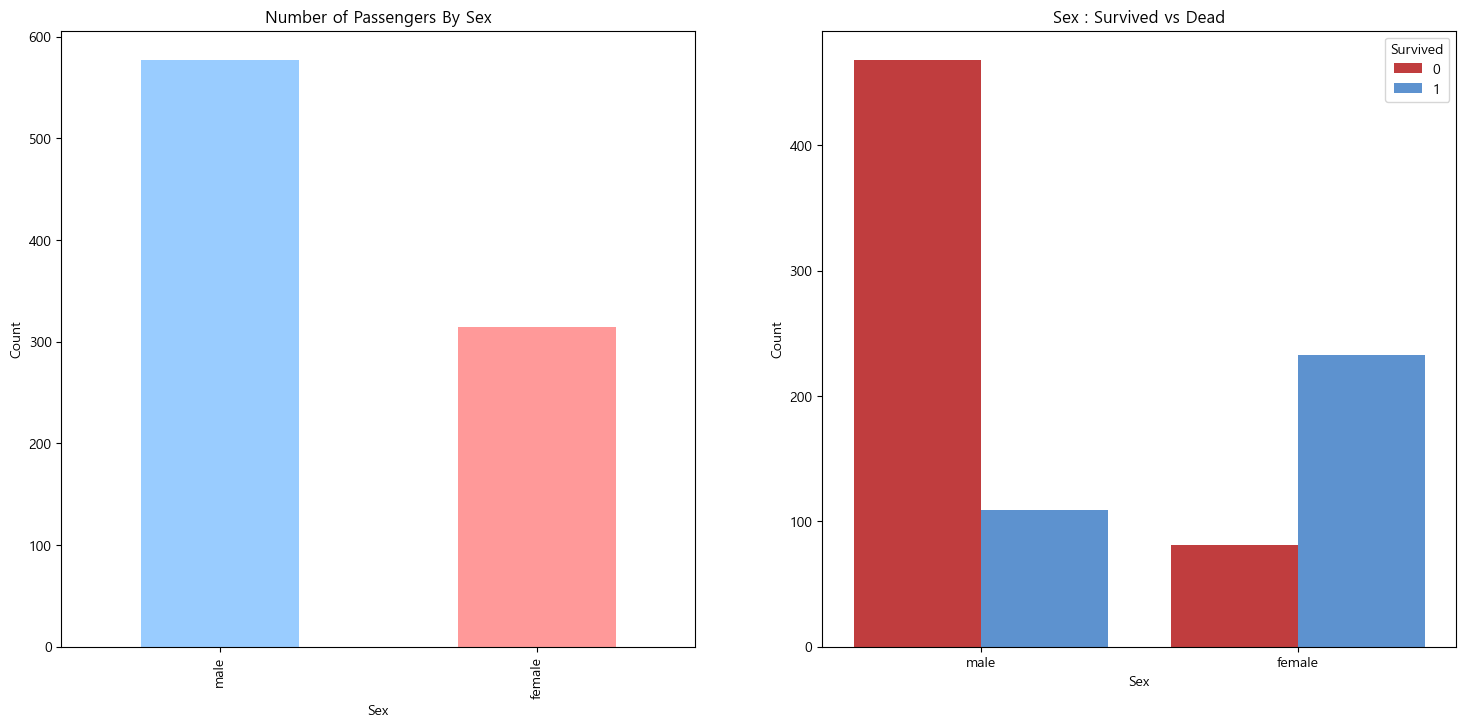

In [22]:
# 시각화

fig, ax = plt.subplots(1, 2, figsize=(18, 8))

df_train['Sex'].value_counts().sort_index(ascending=False).plot.bar(color=['#99ccff', '#ff9999'], ax=ax[0])
ax[0].set_title('Number of Passengers By Sex')
ax[0].set_ylabel('Count')

sns.countplot(data=df_train, x='Sex', hue='Survived', palette=['#d62728', '#4a90e2'], ax=ax[1])
ax[1].set_title('Sex : Survived vs Dead')
ax[1].set_ylabel('Count')

Sex 정리
- 여자가 생존할 확률이 높음
- 생존률 : male, female 순서대로 19%, 75%

## 2.3 Pclass & Sex

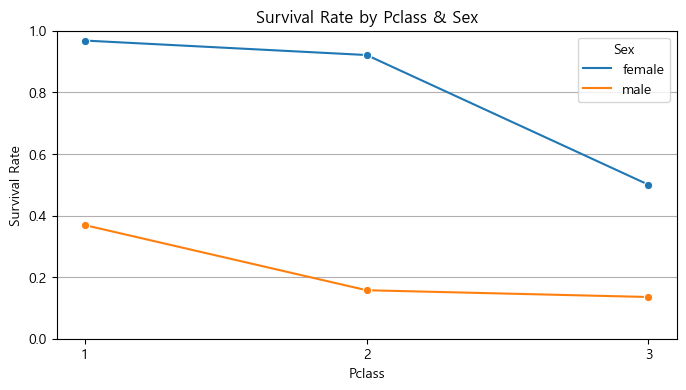

In [23]:
## 시각화

# 생존 비율 계산
survival_rate = df_train.groupby(['Pclass', 'Sex'])['Survived'].mean().reset_index()

plt.subplots(figsize=(8, 4))
sns.lineplot(data=survival_rate, x='Pclass', y='Survived', hue='Sex', marker='o')

plt.title('Survival Rate by Pclass & Sex')
plt.xlabel('Pclass')
plt.ylabel('Survival Rate')
plt.xticks([1, 2, 3])
plt.ylim(0, 1) # y축 범위 조정
plt.grid(axis='y')
plt.show()

Pclass & Sex 정리
- 모든 Pclass에서 female이 살 확률이 male보다 높음
- male, female에 상관없이 Pclass가 높을 수록 살 확률이 높음

## 2.4 Age

In [24]:
# 데이터 확인
print('제일 어린 탑승객 나이 : {:.1f} 살'.format(df_train['Age'].min()))
print('제일 나이 많은 탑승객 나이 : {:.1f} 살'.format(df_train['Age'].max()))
print('평균 탑승객 나이 : {:.1f} 살'.format(df_train['Age'].mean()))

제일 어린 탑승객 나이 : 0.4 살
제일 나이 많은 탑승객 나이 : 80.0 살
평균 탑승객 나이 : 29.7 살


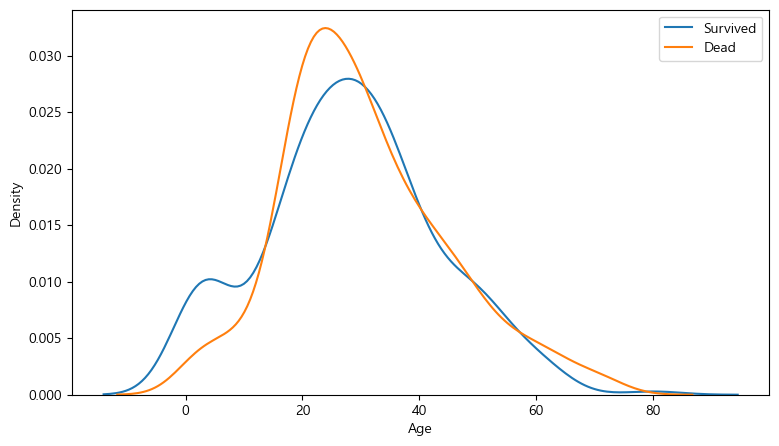

In [25]:
## 연령별 Survived vs Dead
fig, ax = plt.subplots(figsize=(9, 5))

# 커널 밀도 추정(Kernel Density Estimation)
sns.kdeplot(df_train[df_train['Survived'] == 1]['Age'], ax=ax)
sns.kdeplot(df_train[df_train['Survived'] == 0]['Age'], ax=ax)

plt.legend(['Survived', 'Dead'])
plt.show()

Text(0.5, 1.0, 'Age Distribution by Pclass')

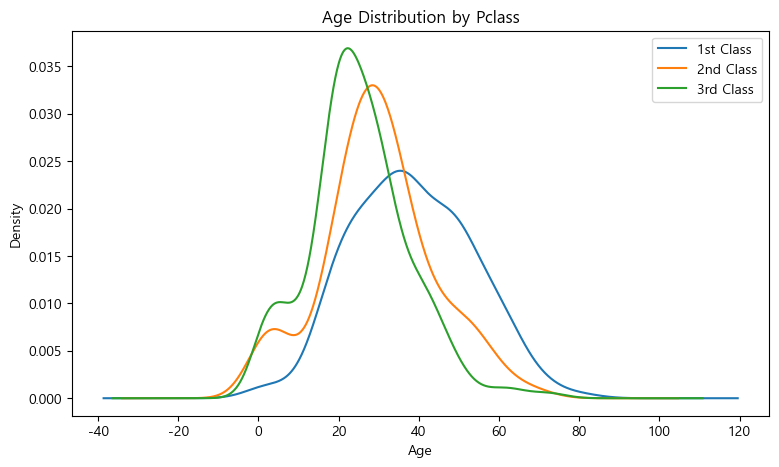

In [26]:
# Pclass별 연령대 시각화
fig, ax = plt.subplots(figsize=(9, 5))

df_train['Age'][df_train['Pclass'] == 1].plot(kind='kde')
df_train['Age'][df_train['Pclass'] == 2].plot(kind='kde')
df_train['Age'][df_train['Pclass'] == 3].plot(kind='kde')

plt.xlabel('Age')
plt.legend(['1st Class', '2nd Class', '3rd Class'])
plt.title('Age Distribution by Pclass')

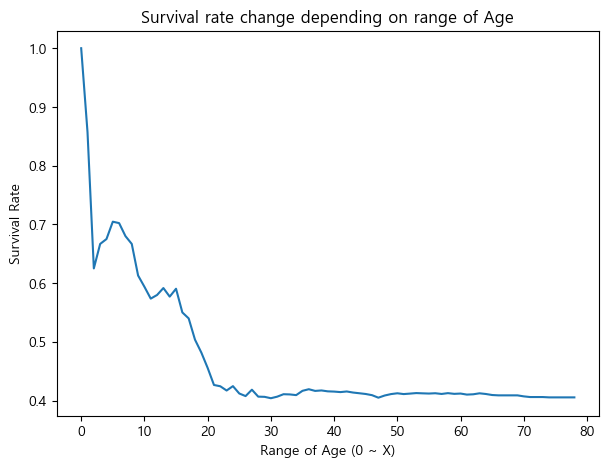

In [27]:
## Age 별 누적 생존률
cummulative_survival_ratio = []

for i in range(1, 80) : # 초고령자 탑승자 : 80살
    cummulative_survival_ratio.append(df_train[df_train['Age'] < i]['Survived'].sum()
                                      / len(df_train[df_train['Age'] < i]['Survived']))

plt.figure(figsize=(7, 5))
plt.plot(cummulative_survival_ratio)

plt.title('Survival rate change depending on range of Age')
plt.xlabel('Range of Age (0 ~ X)')
plt.ylabel('Survival Rate')
plt.show()

## 그래프 해석
# 10세 이하인 사람이 생존할 확률 = 약 58%
# 80세 이하인 사람이 생존할 확률 (탑승객 전원) = 약 40%

Age 정리
- 생존자 중 나이가 어린 경우가 많음
- Pclass가 높을 수록 나이 많은 사람의 비중이 커짐
- 나이가 어릴수록 생존률이 확실히 높음 > 모델을 만들 때 Age 변수를 사용하는 것이 좋음

## 2.5 Pclass & Sex & Age

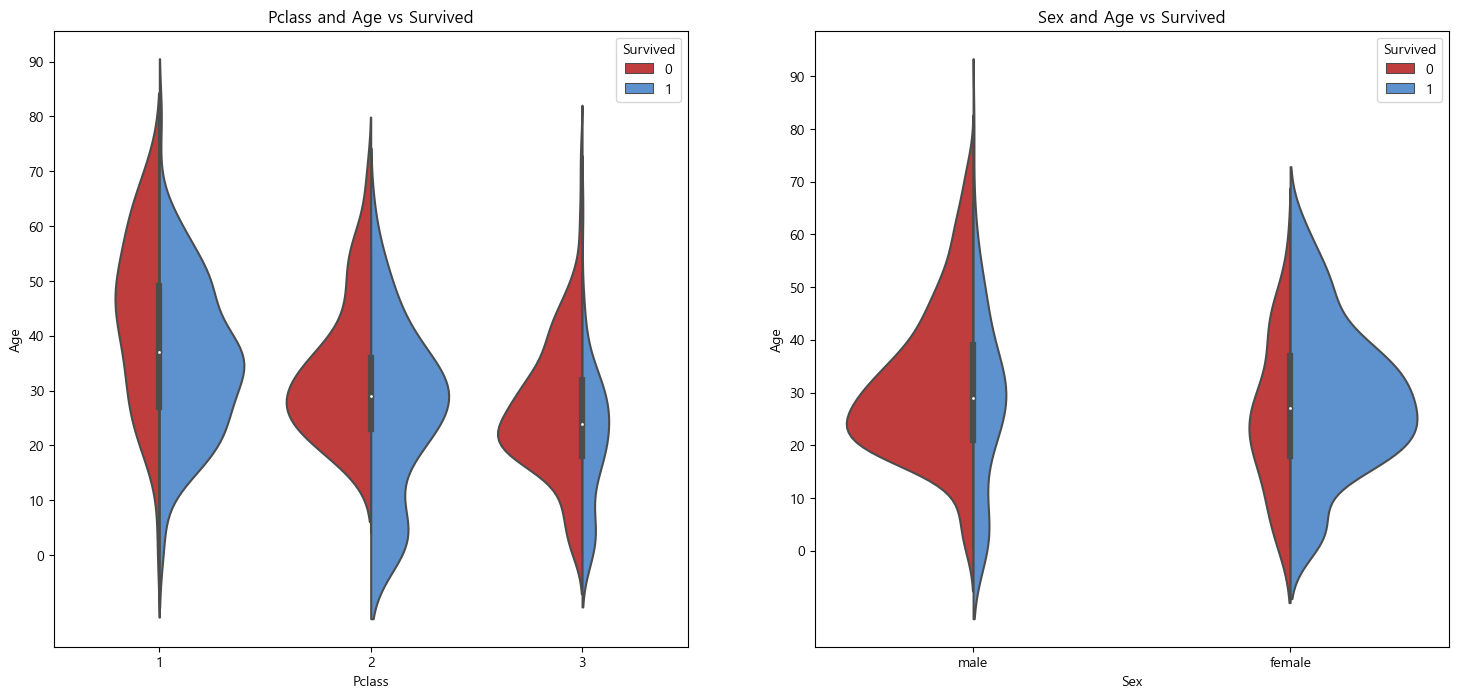

In [28]:
## Violinplot 시각화
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

# scale='count' : 바이올린의 너비를 데이터의 개수에 따라 조절
# split=True : hue 변수에 따라 바이올린을 분할
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0, 100, 10))
sns.violinplot(data=df_train, x='Pclass', y='Age', hue='Survived', scale='count', split=True, palette=['#d62728', '#4a90e2'], ax=ax[0])

ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0, 100, 10))
sns.violinplot(data=df_train, x='Sex', y='Age', hue='Survived', scale='count', split=True, palette=['#d62728', '#4a90e2'], ax=ax[1])

plt.show()

Pclass & Sex & Age 정리
- 생존만 봤을 때, 모든 클래스에서 나이가 어릴수록 생존을 많이 함
- 명확하게 여자가 많이 생존 (오른쪽 그래프)
- 아이와 여성을 먼저 챙김

## 2.6 Embarked

<Axes: xlabel='Embarked'>

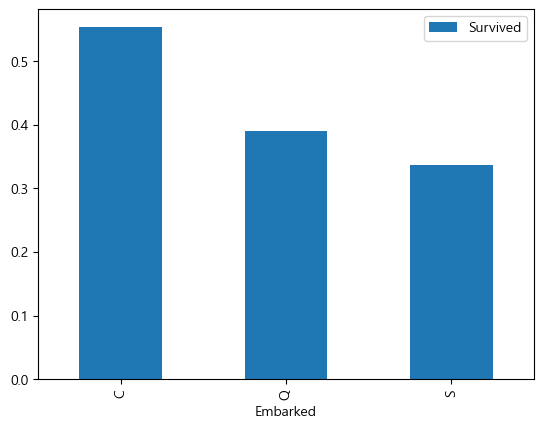

In [29]:
# 탑승 항구별 생존률
df_train[['Embarked', 'Survived']].groupby('Embarked').mean().plot.bar()

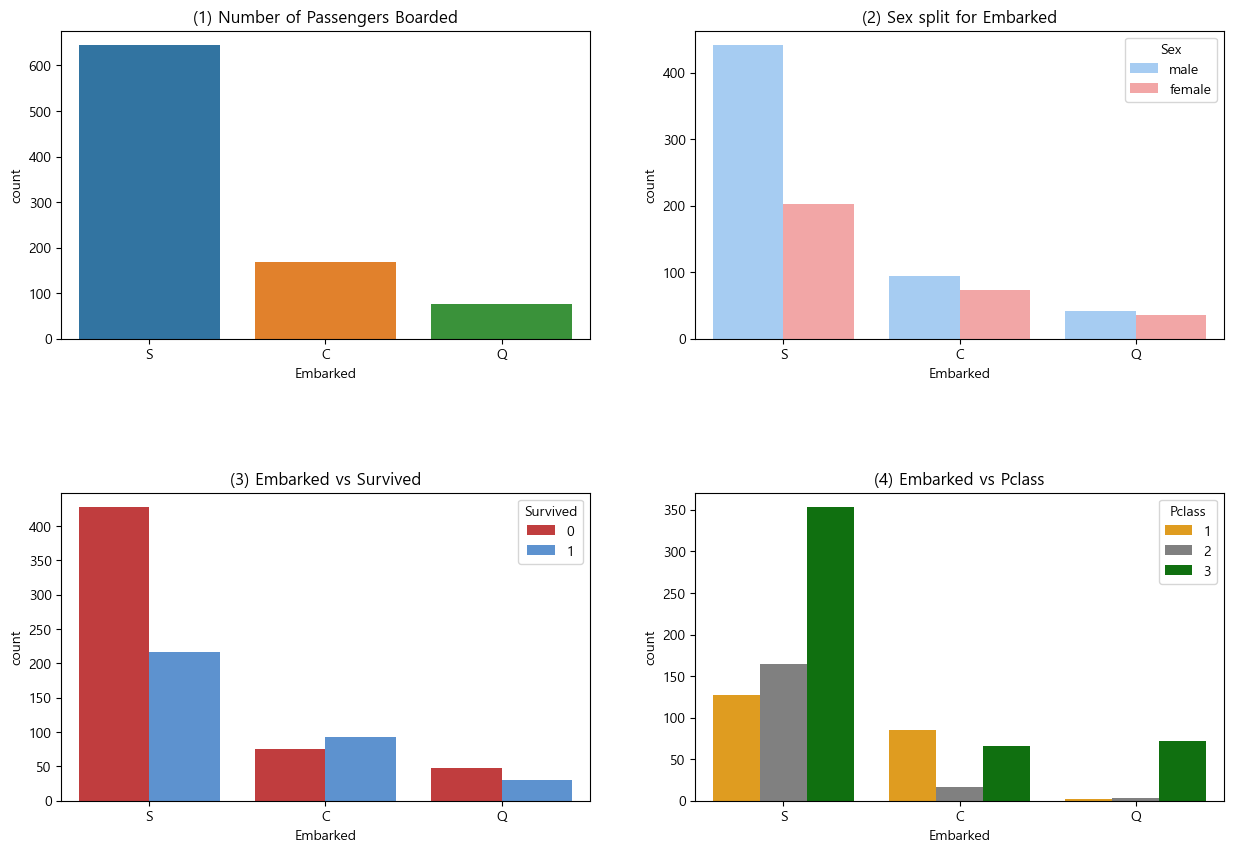

In [30]:
## 시각화
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

ax[0, 0].set_title('(1) Number of Passengers Boarded')
sns.countplot(data=df_train, x='Embarked', ax=ax[0, 0])

ax[0, 1].set_title('(2) Sex split for Embarked')
sns.countplot(data=df_train, x='Embarked', hue='Sex', palette=['#99ccff', '#ff9999'], ax=ax[0, 1])

ax[1, 0].set_title('(3) Embarked vs Survived')
sns.countplot(data=df_train, x='Embarked', hue='Survived', palette=['#d62728', '#4a90e2'], ax=ax[1, 0])

ax[1, 1].set_title('(4) Embarked vs Pclass')
sns.countplot(data=df_train, x='Embarked', hue='Pclass', palette=['orange', 'gray', 'green'], ax=ax[1, 1])

plt.subplots_adjust(wspace=0.2, hspace=0.5) # 서브플롯들 간의 가로/세로 간격 조정
plt.show()

Embarked 정리
- 생존률은 비슷하지만 그래도 C(Cherbourg)가 제일 높음 > 모델에 큰 영향력 미칠까??
- Figure (1) : S(Southampton)에서 가장 많은 사람이 탑승
- Figure (2) : C와 Q(Queenstown)는 남녀의 비율이 비슷하고, S는 남자가 더 많음
- Figure (3) : S의 생존확률이 가장 낮음 (이전 그래프에서도 확인 가능)
- Figure (4) : C의 생존 확률이 높은 이유는 Pclass가 높은 사람이 많이 탐. S는 Pclass가 낮은 사람이 많이 타서 생존 확률이 낮음

## 2.7 Family - SibSp(형제, 배우자) + Parch(부모, 자녀)

In [31]:
# 확인 > 유니크한 탑승객 정보가 담긴 df_train
print('전체 탑승객 수 : %s 명' % len(df_train))
print('유니크한 이름 개수 : %s' % df_train['Name'].nunique())

전체 탑승객 수 : 891 명
유니크한 이름 개수 : 891


In [32]:
## 새로운 열 생성 (Family = SibSP + Parch)
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1 # 자기자신 포함
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1

print('최소 가족 구성원 수 : ', df_train['FamilySize'].min())
print('최대 가족 구성원 수 : ', df_train['FamilySize'].max())

최소 가족 구성원 수 :  1
최대 가족 구성원 수 :  11


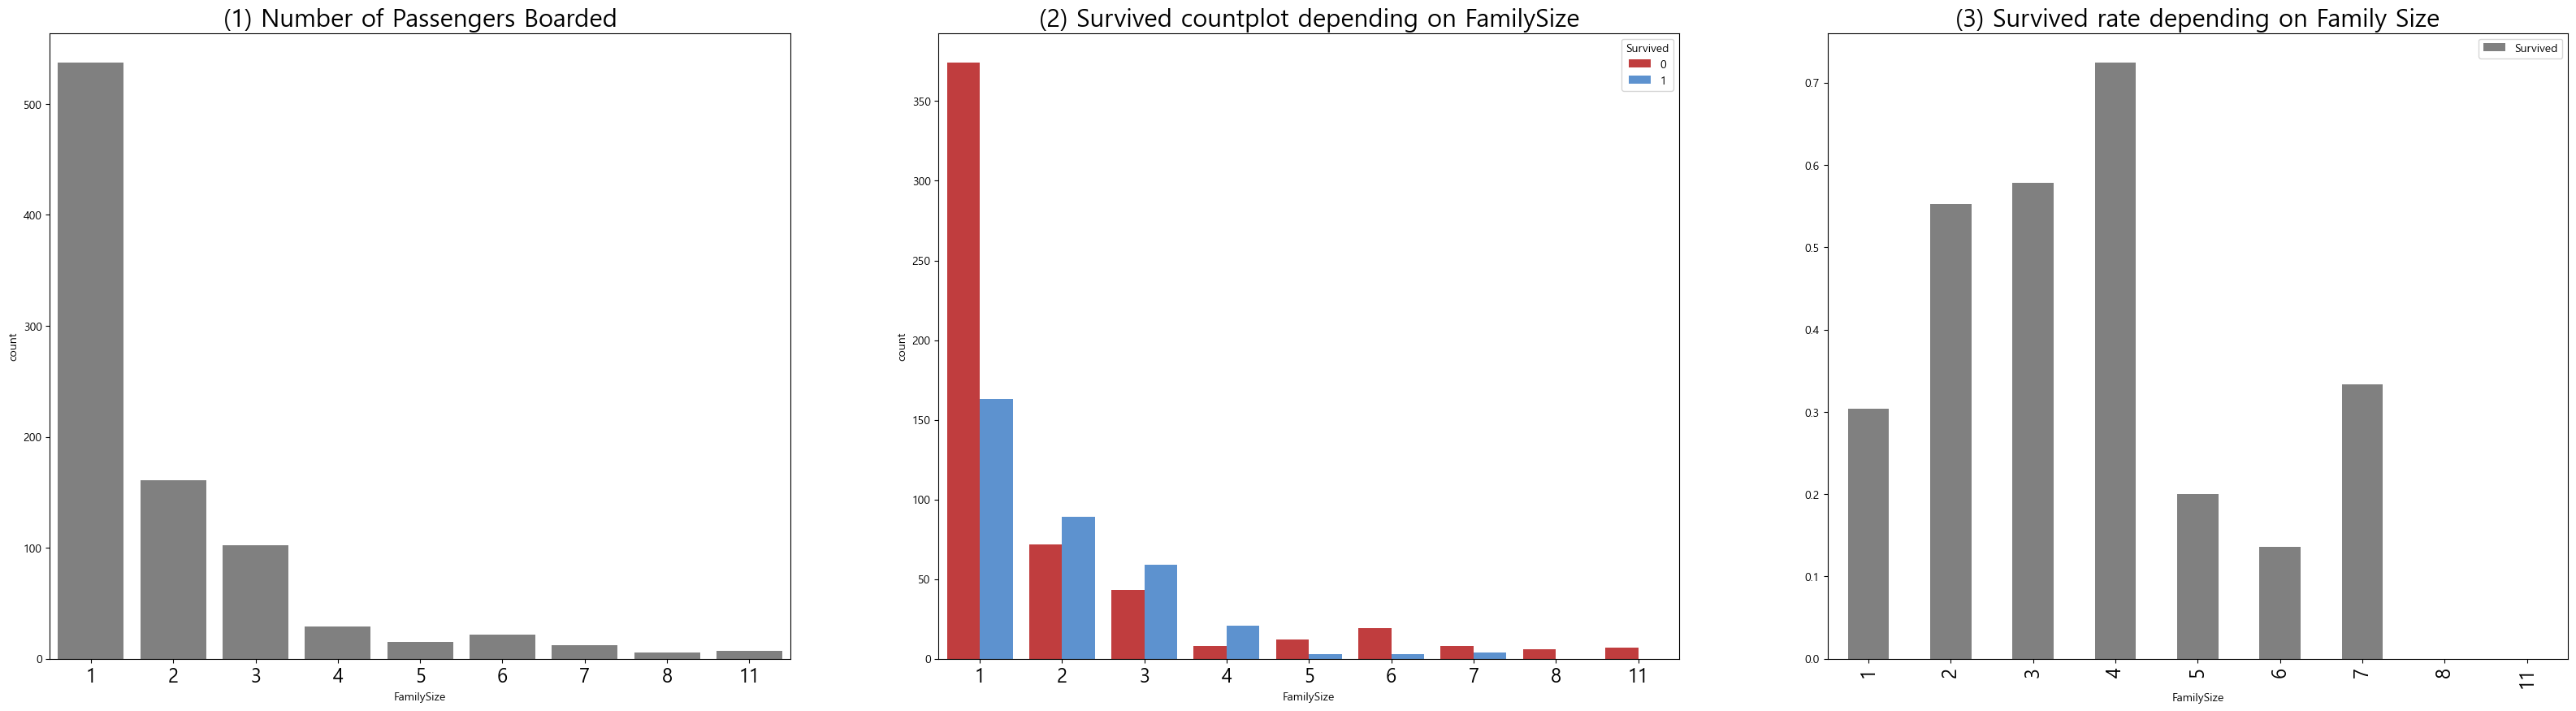

In [33]:
## 시각화
fig, ax = plt.subplots(1, 3, figsize=(40, 10))

ax[0].set_title('(1) Number of Passengers Boarded', fontsize=22)
ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize=17)
sns.countplot(data=df_train, x='FamilySize', color='gray', ax=ax[0])

ax[1].set_title('(2) Survived countplot depending on FamilySize', fontsize=22)
ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize=17)
sns.countplot(data=df_train, x='FamilySize', hue='Survived', palette=['#d62728', '#4a90e2'], ax=ax[1])

ax[2].set_title('(3) Survived rate depending on Family Size', fontsize=22)
ax[2].set_xticklabels(ax[2].get_xticklabels(), fontsize=17)
df_train[['FamilySize', 'Survived']].groupby('FamilySize').mean().plot.bar(color='gray', ax=ax[2])

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Family 정리
- Figure (1) : 대부분 혼자 탑승
- Figure (2) & (3) : 가족이 4명인 경우 생존률이 가장 높음. 가족 수가 너무 작아도 (1명), 너무 커도 (5~11) 생존 확률이 낮음

## 2.8 Fare

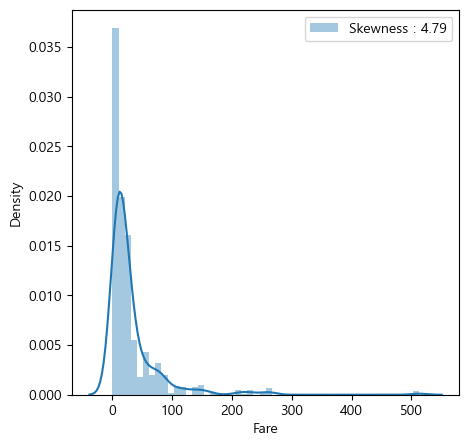

In [34]:
## 탑승 요금 시각화
fig, ax = plt.subplots(figsize=(5, 5))

# displot : 히스토그램 + 커널 밀도 추정
sns.distplot(df_train['Fare'], label='Skewness : {:.2f}'.format(df_train['Fare'].skew()))
plt.legend()

# 해석
# 비대칭적 구조 (high skewness)
# 몇 개 없는 이상치에 너무 민감하게 반응한다면 실제 예측 시 좋은 결과 나타나기 어려움
# outlier의 영향을 줄이기 위해 Fare에 log 함수 적용
# 로그 변환은 데이터의 왜도(Skewness)를 줄이고, 값들이 큰 범위로 분포된 데이터를 더 다루기 쉽게 만드는 데 사용

In [35]:
## df_test의 Fare 결측치 처리
print('df_test 데이터셋의 Fare 결측값 수 : ', df_test['Fare'].isna().sum())

# 평균값으로 치환
df_test.loc[df_test['Fare'].isnull(), 'Fare'] = df_test['Fare'].mean()

# 확인
print('df_test 데이터셋의 Fare 결측값 수 : ', df_test['Fare'].isna().sum())

df_test 데이터셋의 Fare 결측값 수 :  1
df_test 데이터셋의 Fare 결측값 수 :  0


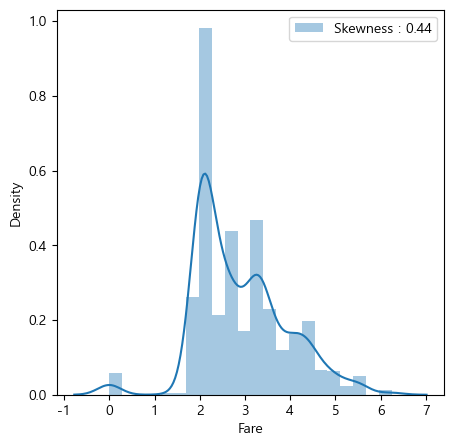

In [36]:
## 탑승 요금 시각화 (로그 변환)

# map : 특정 columns에 공통된 함수 적용
df_train['Fare'] = df_train['Fare'].map(lambda i : np.log(i) if i > 0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i : np.log(i) if i > 0 else 0)

fig, ax = plt.subplots(figsize=(5, 5))

sns.distplot(df_train['Fare'], label='Skewness : {:.2f}'.format(df_train['Fare'].skew()))
plt.legend()

## 2.9 Cabin

In [37]:
# 결측치 비율 > 모델 포함x
df_train['Cabin'].isna().sum() / len(df_train) * 100

77.10437710437711

## 2.10 Ticket

In [38]:
df_train['Ticket'].value_counts().sort_values(ascending=False).head(10)

Ticket
347082          7
1601            7
CA. 2343        7
3101295         6
CA 2144         6
347088          6
S.O.C. 14879    5
382652          5
4133            4
347077          4
Name: count, dtype: int64

# 3. Feature Engineering
- 실제 모델의 학습에 쓰려고 하는 것이기 때문에, train 뿐만 아니라 test에도 똑같이 적용

## 3.1 결측치 채우기

In [39]:
# df_train 결측치 확인
df_train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
FamilySize       0
dtype: int64

In [40]:
# df_test 결측치 확인
df_test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
FamilySize       0
dtype: int64

### 3.1.1 Age
- train (177개) & test (8개)
- 아이디어 : Name에 있는 Ttile (Miss, Mr, Mrs) + train_set의 Statistics 활용

In [41]:
## Title 추출

# 정규 표현식 : 문자열에서 특정한 형태의 데이터를 검색, 매칭, 추출 또는 치환
# str.extract는 기본적으로 첫 번째 매칭만 반환

# 첫 번째로 발견되는 알파벳 대소문자로 이루어진 문자열을 추출하고, 마침표(.)로 끝나는 경우를 반환
df_train['Initial'] = df_train['Name'].str.extract('([A-Za-z]+)\.')
df_test['Initial'] = df_test['Name'].str.extract('([A-Za-z]+)\.')

# 확인
display(df_train['Initial'].value_counts().head())
display(df_test['Initial'].value_counts())

Initial
Mr        517
Miss      182
Mrs       125
Master     40
Dr          7
Name: count, dtype: int64

Initial
Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Ms          1
Dr          1
Dona        1
Name: count, dtype: int64

In [42]:
# Initial와 Sex의 crosstab (df_train)
pd.crosstab(df_train['Sex'], df_train['Initial']).style.background_gradient(cmap='GnBu')

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


In [43]:
## male과 female이 사용하는 Initial 구분 (df_train)
df_train['Initial'].replace(['Don', 'Rev', 'Dr', 'Mme', 'Ms', 'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess', 'Jonkheer']
                            , ['Mr', 'Other', 'Mr', 'Miss', 'Miss', 'Mr', 'Mrs', 'Mr', 'Miss', 'Other', 'Mr', 'Mrs', 'Other'], inplace=True)

# 확인
df_train['Initial'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Other'], dtype=object)

In [44]:
# Initial와 Sex의 crosstab (df_test)
pd.crosstab(df_test['Sex'], df_test['Initial']).style.background_gradient(cmap='GnBu')

Initial,Col,Dona,Dr,Master,Miss,Mr,Mrs,Ms,Rev
Sex,,,,,,,,,
female,0,1,0,0,78,0,72,1,0
male,2,0,1,21,0,240,0,0,2


In [45]:
## Male과 female이 사용하는 Initial 구분 (df_test)
df_test['Initial'].replace(['Ms', 'Col', 'Rev', 'Dr', 'Dona']
                           , ['Miss', 'Other', 'Other', 'Mr', 'Miss'], inplace=True)

# 확인
df_test['Initial'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Other'], dtype=object)

<Axes: xlabel='Initial'>

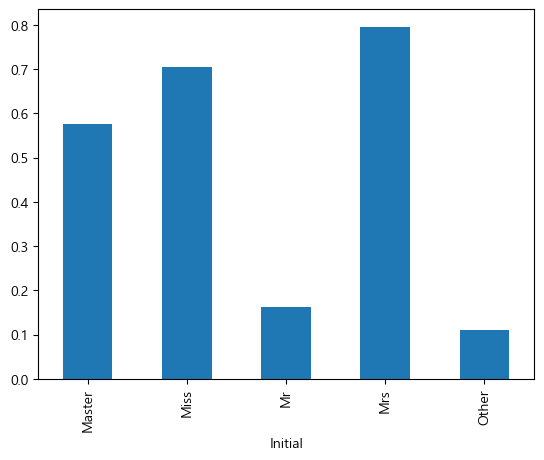

In [46]:
# 시각화
df_train.groupby('Initial')['Survived'].mean().plot.bar()

In [47]:
# Initial 별 수치형 변수 평균 > 여성과 관계있는 Miss, Mrs의 생존률이 높음
df_train.groupby('Initial')[['Survived', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize']].mean()

,Survived,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,
Master,0.575000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,0.704301,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,0.162571,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,0.795276,35.981818,0.692913,0.818898,3.443751,2.511811
Other,0.111111,45.888889,0.111111,0.111111,2.641605,1.222222


In [48]:
## Age 칼럼 Null 처리

# train에서 얻은 statistics를 기반으로 test의 null 채우기
# Age의 평균을 이용해 null 처리

df_train.loc[(df_train['Age'].isnull()) & (df_train['Initial'] == 'Master'), 'Age'] = 5
df_train.loc[(df_train['Age'].isnull()) & (df_train['Initial'] == 'Miss'), 'Age'] = 22
df_train.loc[(df_train['Age'].isnull()) & (df_train['Initial'] == 'Mr'), 'Age'] = 33
df_train.loc[(df_train['Age'].isnull()) & (df_train['Initial'] == 'Mrs'), 'Age'] = 36
df_train.loc[(df_train['Age'].isnull()) & (df_train['Initial'] == 'Other'), 'Age'] = 46

df_test.loc[(df_test['Age'].isnull()) & (df_test['Initial'] == 'Master'), 'Age'] = 5
df_test.loc[(df_test['Age'].isnull()) & (df_test['Initial'] == 'Miss'), 'Age'] = 22
df_test.loc[(df_test['Age'].isnull()) & (df_test['Initial'] == 'Mr'), 'Age'] = 33
df_test.loc[(df_test['Age'].isnull()) & (df_test['Initial'] == 'Mrs'), 'Age'] = 36
df_test.loc[(df_test['Age'].isnull()) & (df_test['Initial'] == 'Other'), 'Age'] = 46

In [49]:
# 결측치 확인
print('df_train의 Age 결측치 개수 : ', df_train['Age'].isna().sum())
print('df_test의 Age 결측치 개수 : ', df_test['Age'].isna().sum())

df_train의 Age 결측치 개수 :  0
df_test의 Age 결측치 개수 :  0


### 3.1.2 Embarked
- train (2개)

In [50]:
df_train['Embarked'].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [51]:
## Embarked 칼럼 Null 처리

# S에 가장 많은 탑승객이 있으므로 null을 S로 대체
df_train['Embarked'].fillna('S', inplace=True)

# 확인
print('df_train의 Embarked 결측치 개수 : ', df_train['Embarked'].isna().sum())

df_train의 Embarked 결측치 개수 :  0


In [52]:
## 최종 결측치 확인
df_train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
FamilySize       0
Initial          0
dtype: int64

In [53]:
df_test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
FamilySize       0
Initial          0
dtype: int64

## 3.2 Age 타입 변환 (Continuous → Categorical)

In [54]:
# Age는 연속형 변수이지만 몇개의 group으로 나누어 category화 가능
# 단, continous를 categorical로 바꾸면 information loss가 생길 수 있음
df_train['Age'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 891 entries, 0 to 890
Series name: Age
Non-Null Count  Dtype  
--------------  -----  
891 non-null    float64
dtypes: float64(1)
memory usage: 7.1 KB


In [55]:
## 10살 간격으로 Grouping

# 방법 1) loc (indexing)]
df_train['Age_cat'] = 0

df_train.loc[df_train['Age'] < 10, 'Age_cat'] = 0
df_train.loc[(10 <= df_train['Age']) & (df_train['Age'] < 20), 'Age_cat'] = 1
df_train.loc[(20 <= df_train['Age']) & (df_train['Age'] < 30), 'Age_cat'] = 2
df_train.loc[(30 <= df_train['Age']) & (df_train['Age'] < 40), 'Age_cat'] = 3
df_train.loc[(40 <= df_train['Age']) & (df_train['Age'] < 50), 'Age_cat'] = 4
df_train.loc[(50 <= df_train['Age']) & (df_train['Age'] < 60), 'Age_cat'] = 5
df_train.loc[(60 <= df_train['Age']) & (df_train['Age'] < 70), 'Age_cat'] = 6
df_train.loc[70 <= df_train['Age'], 'Age_cat'] = 7

df_test['Age_cat'] = 0
df_test.loc[(df_test['Age'] < 10), 'Age_cat'] = 0
df_test.loc[(10 <= df_test['Age']) & (df_test['Age'] < 20), 'Age_cat'] = 1
df_test.loc[(20 <= df_test['Age']) & (df_test['Age'] < 30), 'Age_cat'] = 2
df_test.loc[(30 <= df_test['Age']) & (df_test['Age'] < 40), 'Age_cat'] = 3
df_test.loc[(40 <= df_test['Age']) & (df_test['Age'] < 50), 'Age_cat'] = 4
df_test.loc[(50 <= df_test['Age']) & (df_test['Age'] < 60), 'Age_cat'] = 5
df_test.loc[(60 <= df_test['Age']) & (df_test['Age'] < 70), 'Age_cat'] = 6
df_test.loc[70 <= df_test['Age'], 'Age_cat'] = 7

# 확인
print('df_train의 Age Category : ', df_train['Age_cat'].unique())
print('df_test의 Age Category : ', df_test['Age_cat'].unique())

df_train의 Age Category :  [2 3 5 0 1 4 6 7]
df_test의 Age Category :  [3 4 6 2 1 5 0 7]


In [56]:
# 방법 2) apply
def category_age(x) :
    if x < 10 :
        return 0
    elif x < 20 :
        return 1
    elif x < 30 :
        return 2
    elif x < 40 :
        return 3
    elif x < 50 :
        return 4
    elif x < 60 :
        return 5
    elif x < 70 :
        return 6
    else :
        return 7

# 적용 및 확인
df_train['Age_cat2'] = df_train['Age'].apply(category_age)
df_test['Age_cat2'] = df_test['Age'].apply(category_age)

print('df_train의 Age Category2 : ', df_train['Age_cat2'].unique())
print('df_test의 Age Category2 : ', df_test['Age_cat2'].unique())

df_train의 Age Category2 :  [2 3 5 0 1 4 6 7]
df_test의 Age Category2 :  [3 4 6 2 1 5 0 7]


In [57]:
## 방법 1 & 2 동일 여부 확인

# series간 boolean 비교
# all : 모든 값이 True면 True, 하나라도 Fasle가 있으면 False
print('방법 1과 방법2 결과가 같다면 True, 다르면 False (df_train) : ', (df_train['Age_cat'] == df_train['Age_cat2']).all())
print('방법 1과 방법2 결과가 같다면 True, 다르면 False (df_test) : ', (df_test['Age_cat'] == df_test['Age_cat2']).all())

방법 1과 방법2 결과가 같다면 True, 다르면 False (df_train) :  True
방법 1과 방법2 결과가 같다면 True, 다르면 False (df_test) :  True


In [58]:
# 중복되는 칼럼 & 원본 Age열 삭제
df_train.drop(['Age', 'Age_cat2'], axis=1, inplace=True)
df_test.drop(['Age', 'Age_cat2'], axis=1, inplace=True)

In [59]:
# Age_cat 칼럼은 category형 변수
df_train['Age_cat'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 891 entries, 0 to 890
Series name: Age_cat
Non-Null Count  Dtype
--------------  -----
891 non-null    int64
dtypes: int64(1)
memory usage: 7.1 KB


## 3.3 Initial & Embarked & Sex 타입 변환 (String → Numerical)

In [60]:
# 문자형 칼럼을 컴퓨터가 인식할 수 있도록 수치형 칼럼으로 변환
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     891 non-null    object 
 11  FamilySize   891 non-null    int64  
 12  Initial      891 non-null    object 
 13  Age_cat      891 non-null    int64  
dtypes: float64(1), int64(7), object(6)
memory usage: 97.6+ KB


In [61]:
## 1) Initial 칼럼
df_train['Initial'] = df_train['Initial'].map({'Master' : 0, 'Miss' : 1, 'Mr' : 2, 'Mrs' : 3, 'Other' : 4})
df_test['Initial'] = df_test['Initial'].map({'Master' : 0, 'Miss' : 1, 'Mr' : 2, 'Mrs' : 3, 'Other' : 4})

# 확인
print(df_train['Initial'].unique(), df_test['Initial'].unique())

[2 3 1 0 4] [2 3 1 0 4]


In [62]:
## 2) Embarked 칼럼
df_train['Embarked'] = df_train['Embarked'].map({'C' : 0, 'Q' : 1, 'S' : 2})
df_test['Embarked'] = df_test['Embarked'].map({'C' : 0, 'Q' : 1, 'S' : 2})

# 확인
print(df_train['Embarked'].unique(), df_test['Embarked'].unique())

[2 0 1] [1 2 0]


In [63]:
## 3) Sex 칼럼
df_train['Sex'] = df_train['Sex'].map({'female' : 0, 'male' : 1})
df_test['Sex'] = df_test['Sex'].map({'female' : 0, 'male' : 1})

# 확인
print(df_train['Sex'].unique(), df_test['Sex'].unique())

[1 0] [1 0]


In [64]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    int64  
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     891 non-null    int64  
 11  FamilySize   891 non-null    int64  
 12  Initial      891 non-null    int64  
 13  Age_cat      891 non-null    int64  
dtypes: float64(1), int64(10), object(3)
memory usage: 97.6+ KB


Text(0.5, 1.05, 'Pearson Correlation of Features')

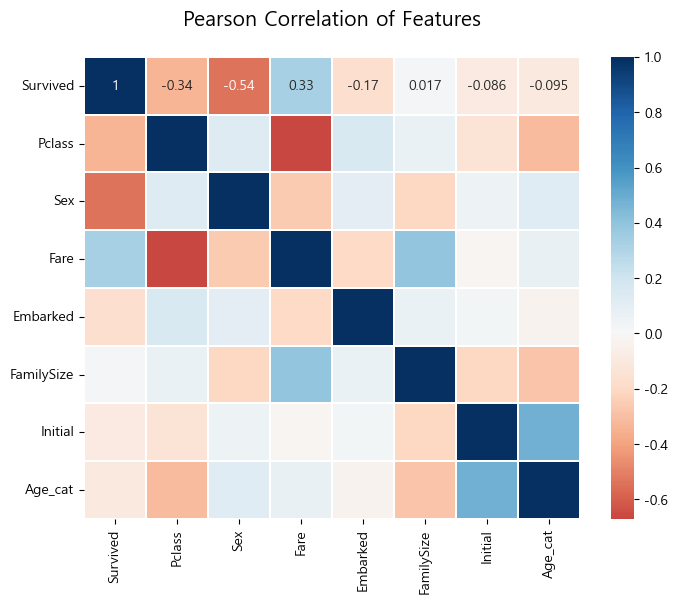

In [65]:
## Feature 간의 상관관계
heatmap = df_train[['Survived', 'Pclass', 'Sex', 'Fare', 'Embarked', 'FamilySize', 'Initial', 'Age_cat']]

plt.figure(figsize=(8, 6))

sns.heatmap(heatmap.astype(float).corr(), cmap=plt.cm.RdBu, annot=True, annot_kws={'size' : 10}, center=0
            , linewidths=0.1, linecolor='white')
plt.title('Pearson Correlation of Features', size=15, y=1.05)

In [66]:
heatmap.astype(float).corr()

,Survived,Pclass,Sex,Fare,Embarked,FamilySize,Initial,Age_cat
Survived,1.000000,-0.338481,-0.543351,0.331805,-0.167675,0.016639,-0.085529,-0.095002
Pclass,-0.338481,1.000000,0.131900,-0.670489,0.162098,0.065997,-0.133054,-0.314809
Sex,-0.543351,0.131900,1.000000,-0.264751,0.108262,-0.200988,0.051687,0.122917
Fare,0.331805,-0.670489,-0.264751,1.000000,-0.199932,0.389193,-0.019889,0.077791
Embarked,-0.167675,0.162098,0.108262,-0.199932,1.000000,0.066516,0.026550,-0.033173
FamilySize,0.016639,0.065997,-0.200988,0.389193,0.066516,1.000000,-0.204574,-0.280537
Initial,-0.085529,-0.133054,0.051687,-0.019889,0.026550,-0.204574,1.000000,0.481309
Age_cat,-0.095002,-0.314809,0.122917,0.077791,-0.033173,-0.280537,0.481309,1.000000


Feature간의 상관관계 정리
- Pclass와 Sex가 Survived와 강한 상관 관계를 가짐
- 서로 강한 상관 관계를 가지는 feature들이 없음
- 이것은 모델을 학습시킬 때, 불필요한 feature가 없다는 것을 의미 (강한 상관관계를 가진 feature가 있다면 우리가 얻을 수 있는 정보는 사실 하나에 불과)

## 3.4 One-Hot Encoding (Initial & Embarked)

One-Hot Encoding
- 범주형 데이터를 이진 벡터로 변환하는 방식
- 범주형 데이터는 보통 문자열이나 특정 값으로 표현되는데, 기계 학습 모델은 숫자 데이터를 처리하기 때문에 범주형 데이터를 숫자로 변환해야함. 이때 원핫인코딩을 사용하여 각 범주를 이진 값(0과 1)으로 변환
- ex. Embarked는 3개의 카테고리로 이루어져 있으므로 one-hot encoding을 통해 새로운 3개의 칼럼이 생성

In [67]:
# One-Hot Encoding
df_train = pd.get_dummies(df_train, columns=['Initial'], prefix='Initial')
df_train = pd.get_dummies(df_train, columns=['Embarked'], prefix='Embarked')

df_test = pd.get_dummies(df_test, columns=['Initial'], prefix='Initial')
df_test = pd.get_dummies(df_test, columns=['Embarked'], prefix='Embarked')

In [68]:
# 확인
df_train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,1.981001,NaN,2,2,False,False,True,False,False,False,False,True
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,PC 17599,4.266662,C85,2,3,False,False,False,True,False,True,False,False


## 3.5 Drop Columns

In [69]:
df_train.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)
df_test.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [70]:
# 최종 데이터프레임 확인
print(df_train.shape)
df_train.head(2)

(891, 14)


,Survived,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,0,3,1,1.981001,2,2,False,False,True,False,False,False,False,True
1,1,1,0,4.266662,2,3,False,False,False,True,False,True,False,False


In [71]:
print(df_test.shape)
df_test.head(2)

(418, 13)


,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,3,1,2.05786,1,3,False,False,True,False,False,False,True,False
1,3,0,1.94591,2,4,False,False,False,True,False,False,False,True


# 4. Machine Learning 모델 구축 및 예측

In [72]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier  # RandomForestClassifier : 이진분류
from sklearn import metrics

## 4.1 Split data into Train, Valid, Test set

In [73]:
# 학습 데이터와 target 데이터 분리
X = df_train.drop('Survived', axis=1).values
y = df_train['Survived'].values

X_test = df_test.values

In [74]:
X_train, X_valid, y_train, y_valid = train_test_split(X
                                                      , y
                                                      , test_size=0.3
                                                      , random_state=2018)

## 4.2 Model Generation and Prediction

In [75]:
model = RandomForestClassifier()

# 모델 학습
model.fit(X_train, y_train)

# 예측 및 평가
pred_y = model.predict(X_valid)

In [76]:
## 성능 확인
# 파라미터 튜닝을 하지 않아도 약 82%의 정확도가 나옴
print('총 {}명 중 {:.2f}% 정확도로 생존을 맞춤'.format(len(y_valid), 100 * metrics.accuracy_score(pred_y, y_valid)))

총 268명 중 81.72% 정확도로 생존을 맞춤


## 4.3 Feature Importance

Random Forest는 Feature의 중요도를 확인 할 수 있음 <br>
즉, 만든 모델이 어떤 Feature에 영향을 많이 받았는지 확인할 수 있음

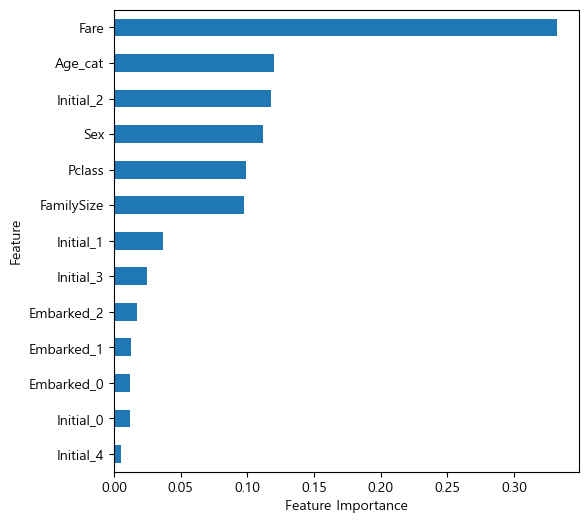

In [77]:
from pandas import Series

feature_importance = model.feature_importances_
Series_feat_imp = Series(feature_importance, index=df_test.columns)

plt.figure(figsize=(6, 6))
Series_feat_imp.sort_values(ascending=True).plot.barh()

plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

Feature Importance 정리
- 변수의 중요도 : Fare > Age_cat > Initial_2 > Sex
- 사용한 모델이 달라지면 Feature Importance는 다르게 나옴
- Fare가 가장 중요한 Feature일 수 있다는 판단을 내릴 수는 있지만, 이것은 결국 모델에 귀속되는 하나의 결론이므로 통계적으로 좀 더 살펴봐야 함
- Feature Importance의 정확도를 높이기 위해서는 feature selection이나 feature를 제거하는 등 다양한 방법이 있음

## 4.4 Prediction On Test set

In [78]:
## 제출 파일 불러 오기 

# df_test와 동일한 PassengerId와 임의로 배정된 Survived 칼럼
submission = pd.read_csv("gender_submission.csv")

print(submission.shape)
submission.head()

(418, 2)


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [79]:
# 최종 예측
prediction = model.predict(X_test)

submission['Survived'] = prediction

submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [80]:
# 결과물 저장
submission.to_csv("submission.csv", index=False)